In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.spatial.distance import pdist, squareform
import plotly.offline as py
from tqdm import tqdm
from sklearn.decomposition import PCA

# for dataset visibility
pd.set_option('display.max_columns', None)

# Set a seed for reproducibility
np.random.seed(42)
df_merged_clusterB = pd.read_hdf('../../ds/cleaned/reduced_for_clustering.h5')
df_merged_clusterB.head()

,date,state,city_or_county,latitude,longitude,congressional_district,participant_age_group1,participant_gender1,avg_age_participants,n_participants_child,n_participants_teen,n_females,n_injured,n_arrested,n_unharmed,incident_characteristics1,povertyPercentage,party,candidatevotes,male_indicator,ratio_killed,death_level,percentage_injured,unharmed_ratio,density_incident_state,males_to_females_ratio
0,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,Adult 18+,Male,26,0,0,0,1,0,1,Shot - Wounded/Injured,16.8,REPUBLICAN,110789.0,3.00,0.0,No deaths,58.789954,2.345189,0.136149,2.0
1,2014-01-01,California,Bakersfield,35.3229,-119.0380,23,Adult 18+,Male,28,0,0,0,2,0,0,Shot - Wounded/Injured,14.5,REPUBLICAN,100317.0,4.50,0.0,No deaths,45.310907,2.345189,0.639968,2.0
2,2014-01-01,Iowa,Iowa City,41.6611,-91.5302,2,Adult 18+,Female,35,0,0,2,1,0,1,other,10.1,DEMOCRAT,143431.0,2.25,0.0,No deaths,71.662763,2.345189,0.096973,0.0
3,2014-01-01,New York,Brooklyn,40.6505,-73.9573,9,Adult 18+,Male,29,0,0,1,3,0,0,Shot - Wounded/Injured,13.4,DEMOCRAT,70997.0,1.50,0.0,No deaths,70.237122,2.345189,0.534650,2.0
4,2014-01-01,Colorado,Grand Junction,39.0496,-108.5250,3,Adult 18+,Male,47,0,0,0,0,0,0,"Shot - Dead (murder, accidental, suicide)",10.2,REPUBLICAN,163011.0,3.00,1.0,All deaths,43.229167,2.345189,0.097775,1.0


# Density-based clustering

DBSCAN: start from data distribution, count #points close to each point, like a circle and overlap. Define a core points: es a point that is close to at least n points (defined by user), randomly pick a core point, assign it to a cluster. Others core points close to the 1st cluster are added (cuz the circle overlap them), go on... then add non-core point if just is close to a core point


In [3]:
df_merged_clusterB['avg_incident_density_per_district'] = df_merged_clusterB.groupby('congressional_district')['density_incident_state'].transform('sum') #avg
df_merged_clusterB['death_level'] = df_merged_clusterB['death_level'].map({'No deaths': 0, 'Some deaths': 1, 'All deaths': 2})
df_merged_clusterB.head()


,date,state,city_or_county,latitude,longitude,congressional_district,participant_age_group1,participant_gender1,avg_age_participants,n_participants_child,n_participants_teen,n_females,n_injured,n_arrested,n_unharmed,incident_characteristics1,povertyPercentage,party,candidatevotes,male_indicator,ratio_killed,death_level,percentage_injured,unharmed_ratio,density_incident_state,males_to_females_ratio,avg_incident_density_per_district
0,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,Adult 18+,Male,26,0,0,0,1,0,1,Shot - Wounded/Injured,16.8,REPUBLICAN,110789.0,3.00,0.0,0,58.789954,2.345189,0.136149,2.0,3650.793607
1,2014-01-01,California,Bakersfield,35.3229,-119.0380,23,Adult 18+,Male,28,0,0,0,2,0,0,Shot - Wounded/Injured,14.5,REPUBLICAN,100317.0,4.50,0.0,0,45.310907,2.345189,0.639968,2.0,420.521167
2,2014-01-01,Iowa,Iowa City,41.6611,-91.5302,2,Adult 18+,Female,35,0,0,2,1,0,1,other,10.1,DEMOCRAT,143431.0,2.25,0.0,0,71.662763,2.345189,0.096973,0.0,5324.818169
3,2014-01-01,New York,Brooklyn,40.6505,-73.9573,9,Adult 18+,Male,29,0,0,1,3,0,0,Shot - Wounded/Injured,13.4,DEMOCRAT,70997.0,1.50,0.0,0,70.237122,2.345189,0.534650,2.0,2225.749104
4,2014-01-01,Colorado,Grand Junction,39.0496,-108.5250,3,Adult 18+,Male,47,0,0,0,0,0,0,"Shot - Dead (murder, accidental, suicide)",10.2,REPUBLICAN,163011.0,3.00,1.0,2,43.229167,2.345189,0.097775,1.0,3220.168301


In [4]:
stato_con_massima_povertà = df_merged_clusterB.loc[df_merged_clusterB['povertyPercentage'].idxmax()]

# Stampa le informazioni sullo stato con la più alta povertyPercentage
print("Stato con la più alta povertyPercentage:")
print(stato_con_massima_povertà[['state', 'povertyPercentage']])


Stato con la più alta povertyPercentage:
state                Mississippi
povertyPercentage           20.8
Name: 16, dtype: object


Poorest state is not anymore the New Mexico beacuse we have dropped past years, so let's analyse the Mississippi

In [5]:
# show all different values for death_level 
df_merged_clusterB['death_level'].unique()

[0, 2, 1]
Categories (3, int64): [0 < 1 < 2]

In [6]:
# convert the categories of death_level in integer for each category

df_merged_clusterB['death_level'].unique()


[0, 2, 1]
Categories (3, int64): [0 < 1 < 2]

In [7]:
col_clustering_dbscan = ['avg_age_participants','avg_incident_density_per_district','congressional_district','povertyPercentage','death_level'] 
#col_clustering_dbscan = ['avg_age_participants','percentage_injured','avg_incident_density_per_district','n_killed'] 
#aggiungendo congressional district trova 1 cluster in piu

 
#col_clustering_dbscan= ['unharmed_ratio','males_to_females_ratio','totalvotes','density_incident_state','congressional_district']
df_for_dbscan = df_merged_clusterB[col_clustering_dbscan]
df_mississippi =  df_merged_clusterB[df_merged_clusterB['state'] == 'Texas']
df_mississippi_clustering = df_mississippi[col_clustering_dbscan]

# Standardizzazione dei dati
scaler = StandardScaler()
df_mississippi_scaled = scaler.fit_transform(df_mississippi_clustering)

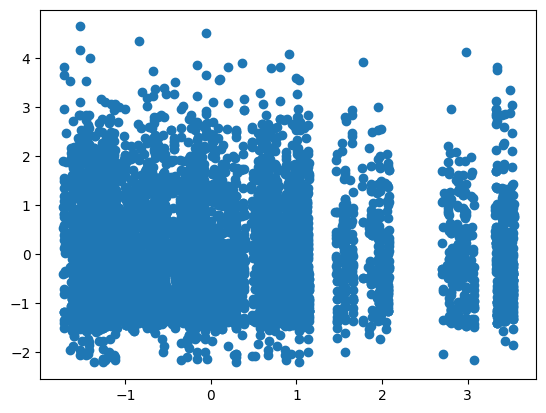

In [8]:
pca = PCA(n_components=3)
df_mississippi_pca = pca.fit_transform(df_mississippi_scaled)
plt.scatter(df_mississippi_pca[:,0], df_mississippi_pca[:,1])

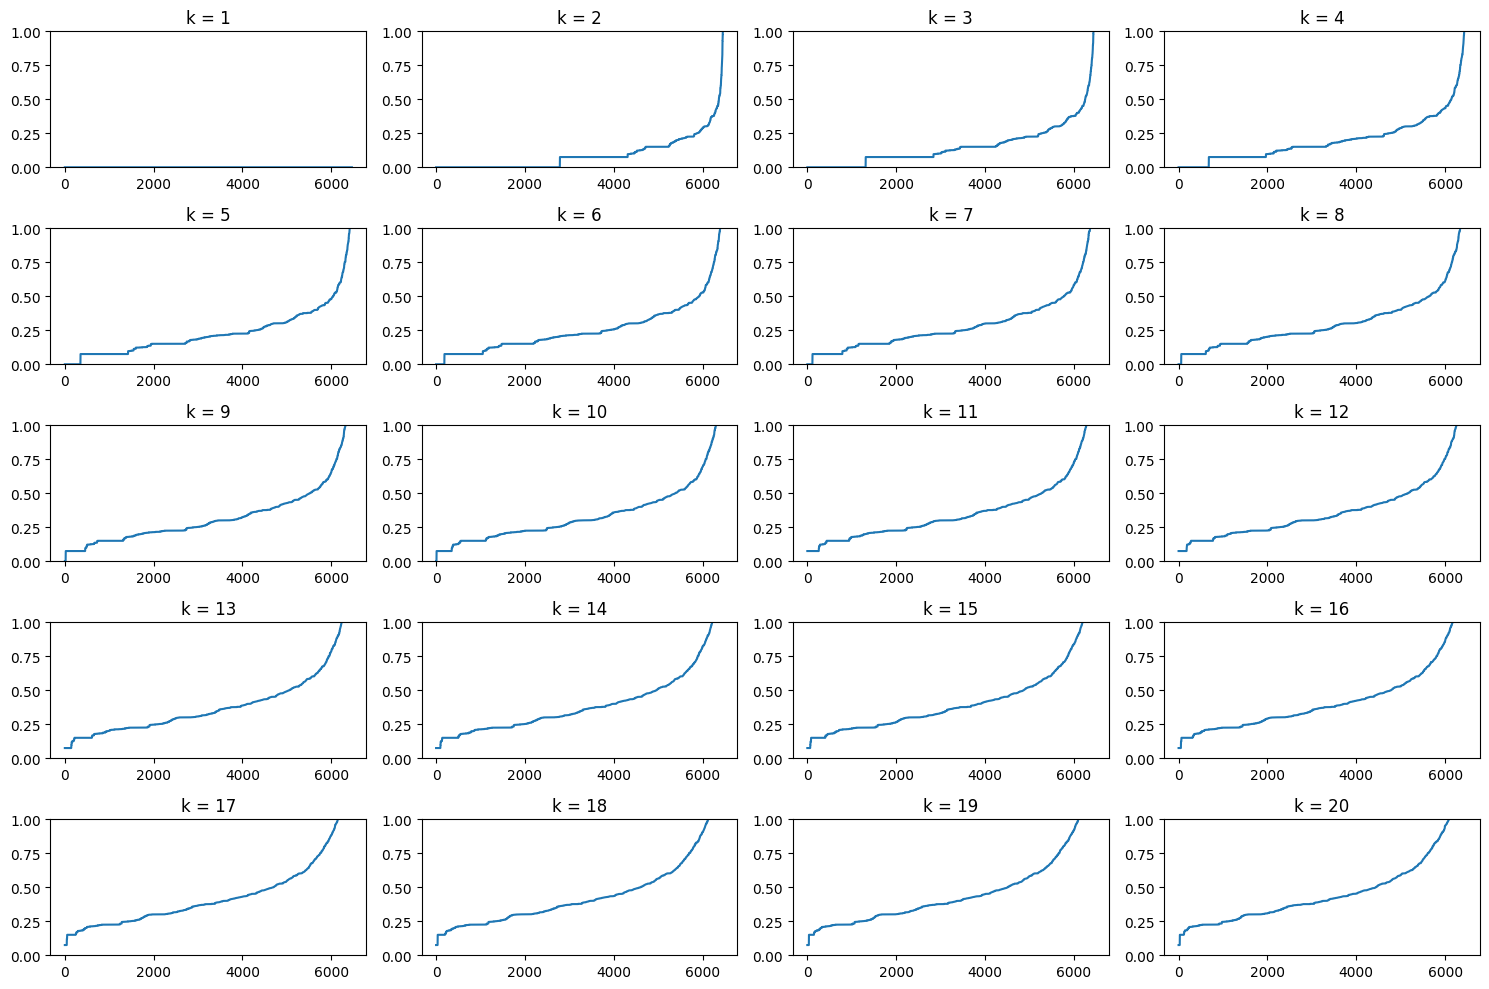

In [9]:
from sklearn.neighbors import NearestNeighbors
max_k = 20
nbrs = NearestNeighbors(n_neighbors=max_k).fit(df_mississippi_scaled)
fig , ax = plt.subplots(5, 4, figsize=(15,10))
for k in range(max_k):
    distances, indices = nbrs.kneighbors(df_mississippi_scaled)
    distances = np.sort(distances, axis=0)
    distances = distances[:,k]
    ax[k//4, k%4].plot(distances)
    ax[k//4, k%4].set_title('k = {}'.format(k+1))
    ax[k//4, k%4].set_ylim([0, 1])
plt.tight_layout()

In [10]:
dbscan= DBSCAN(eps=0.9, min_samples=15).fit(df_mississippi_scaled)
df_mississippi['cluster_dbscan'] = dbscan.labels_
df_mississippi['cluster_dbscan'].value_counts()

/tmp/ipykernel_163832/2846403048.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cluster_dbscan
 5     1647
 11     844
 7      813
 1      702
 12     506
 6      458
 0      383
 13     316
 2      190
-1      161
 8      127
 14      91
 9       77
 3       44
 4       38
 15      35
 10      32
Name: count, dtype: int64

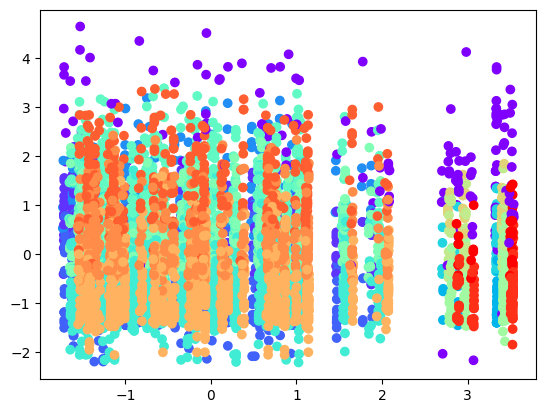

In [11]:
plt.scatter(df_mississippi_pca[:,0], df_mississippi_pca[:,1], c=df_mississippi['cluster_dbscan'], cmap='rainbow')

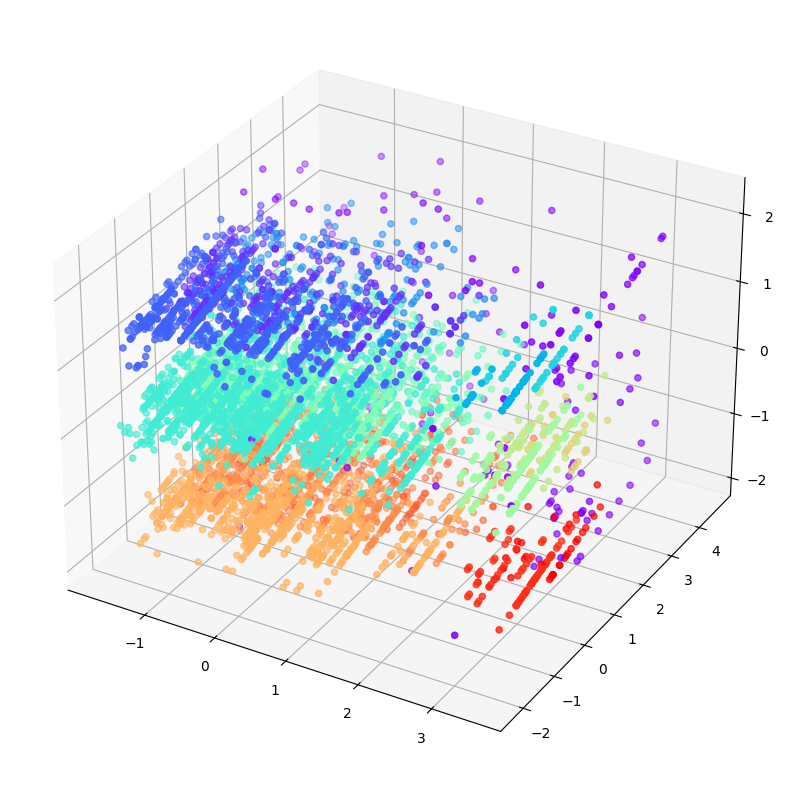

In [12]:
#plot 3d
pca= PCA(n_components=3)
df_ca_pca = pca.fit_transform(df_mississippi_scaled)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_ca_pca[:,0], df_ca_pca[:,1], df_ca_pca[:,2], c=df_mississippi['cluster_dbscan'], cmap='rainbow')

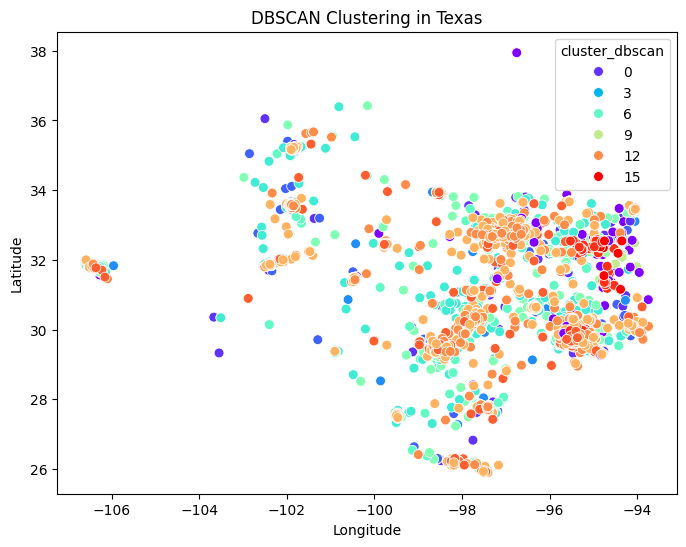

In [14]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='longitude', y='latitude', hue='cluster_dbscan', data=df_mississippi, palette='rainbow', s=50)
plt.title('DBSCAN Clustering in Texas')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

ValueError: 'c' argument has 6464 elements, which is inconsistent with 'x' and 'y' with size 0.

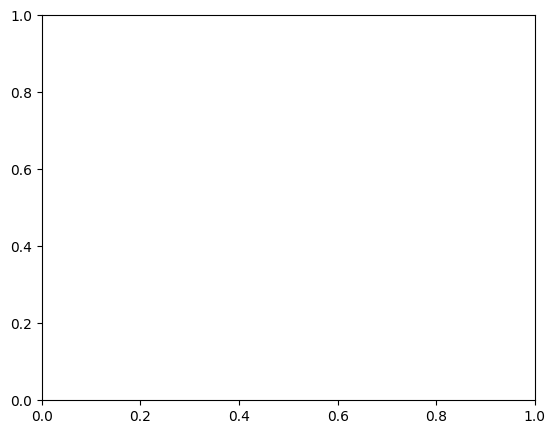

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load the shapefile of Illinois
illinois_shapefile = '../../map_data/texas_shape.shp'
illinois_map = gpd.read_file(illinois_shapefile)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)

# Get the unique clusters
clusters = df_mississippi['cluster_dbscan'].unique()

# Create a colormap
cmap = plt.cm.viridis

# Restrict only to Illinois state
df_merged_clustering = df_mississippi[df_mississippi['state'] == 'Illinois']

# Normalize the colormap
norm = plt.Normalize(df_mississippi['cluster_dbscan'].min(), df_mississippi['cluster_dbscan'].max())

# Create a scatter plot
sc = plt.scatter(df_mississippi['longitude'][:6464], df_mississippi['latitude'][:6464],
                 c=df_mississippi['cluster_dbscan'][:6464], cmap='viridis', s=10, alpha=0.7)

# Plot the Illinois state boundaries
illinois_map.plot(ax=plt.gca(), color='none', edgecolor='black')

# Calculate cluster sizes
cluster_sizes = df_mississippi['cluster_dbscan'].value_counts()

# Create a list of patches for the legend including cluster size
patches = [mpatches.Patch(color=cmap(norm(cluster)), label=f'Cluster {cluster} ({cluster_sizes[cluster]} points)') for cluster in clusters]

# Add the legend to the plot
plt.legend(handles=patches)

plt.title('DBSCAN Clustering on Texas')
plt.tight_layout()
plt.show()


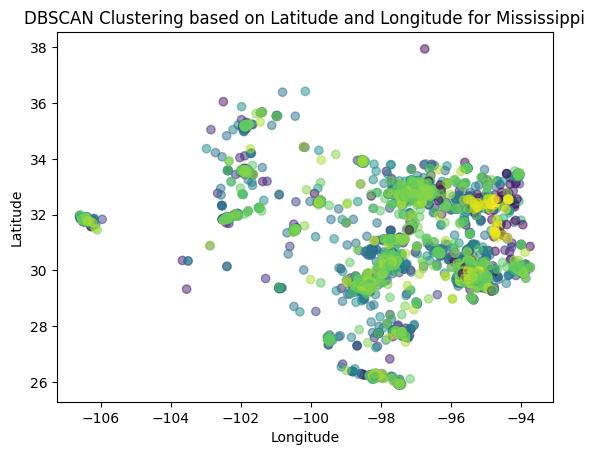

In [ ]:
# Visualizza i risultati del clustering in base a latitudine e longitudine
plt.scatter(df_mississippi['longitude'], df_mississippi['latitude'], c=df_mississippi['cluster_dbscan'], cmap='viridis', marker='o', alpha=0.5)
plt.title('DBSCAN Clustering based on Latitude and Longitude for Mississippi')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


/tmp/ipykernel_84293/2855713833.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



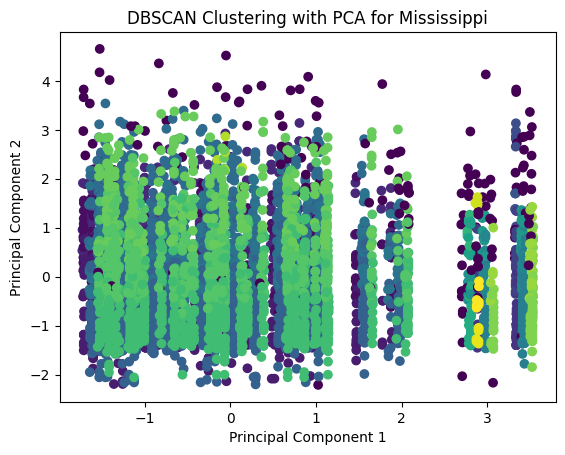

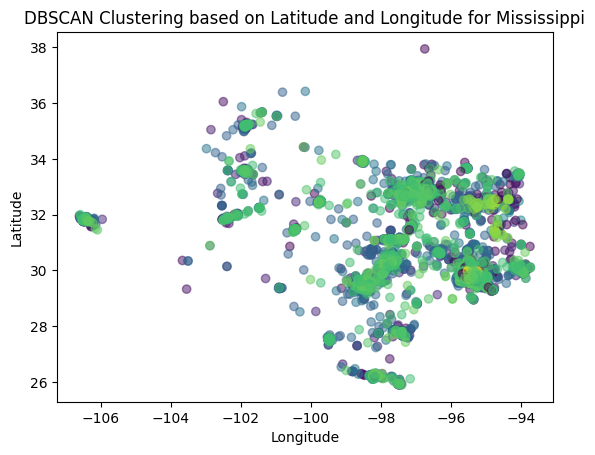

Numero totale di cluster: 27
Cluster 0: 381 elementi
Caratteristiche del cluster:
                                date    latitude   longitude  \
count                            381  381.000000  381.000000   
mean   2014-07-20 01:57:09.921259776   30.745285  -97.434634   
min              2014-01-01 00:00:00   25.894100 -106.502000   
25%              2014-05-04 00:00:00   29.600800  -98.431700   
50%              2014-07-23 00:00:00   30.097700  -97.117700   
75%              2014-10-25 00:00:00   32.683400  -95.488100   
max              2014-12-31 00:00:00   36.050600  -93.874000   
std                              NaN    1.890466    2.437927   

       congressional_district  avg_age_participants  n_participants_child  \
count              381.000000            381.000000            381.000000   
mean                21.763780             33.073491              0.020997   
min                  3.000000             12.000000              0.000000   
25%                 14.000000    

In [ ]:
# priciapal component analysis
from sklearn.decomposition import PCA


#dbscan
eps = 0.6  # Distanza massima tra due campioni per essere considerati nello stesso vicinato
min_samples = 5  # Numero minimo di campioni in un vicinato per essere considerati un cluster
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
df_mississippi['cluster_labels'] = dbscan.fit_predict(df_mississippi_scaled)

#nice values eps = 0.6, min_samples = 5

#pca
pca=PCA(n_components=3)
mississippi_pca = pca.fit_transform(df_mississippi_scaled)
#plt.scatter(mississippi_pca[:,0], mississippi_pca[:,1])
plt.scatter(mississippi_pca[:, 0], mississippi_pca[:, 1], c=df_mississippi['cluster_labels'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN Clustering with PCA for Mississippi')
plt.show()

# Visualizza i risultati del clustering in base a latitudine e longitudine
plt.scatter(df_mississippi['longitude'], df_mississippi['latitude'], c=df_mississippi['cluster_labels'], cmap='viridis', marker='o', alpha=0.5)
plt.title('DBSCAN Clustering based on Latitude and Longitude for Mississippi')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()



# Calcola il numero totale di cluster
n_clusters = len(set(df_mississippi['cluster_labels'])) - (1 if -1 in df_mississippi['cluster_labels'] else 0)
print(f"Numero totale di cluster: {n_clusters}")

# Stampa informazioni sui singoli cluster
for cluster_label in set(df_mississippi['cluster_labels']):
    if cluster_label == -1:
        print(f"Cluster NOISE (outlier): {len(df_mississippi[df_mississippi['cluster_labels'] == cluster_label])} elementi")
    else:
        cluster_data = df_mississippi[df_mississippi['cluster_labels'] == cluster_label]
        print(f"Cluster {cluster_label}: {len(cluster_data)} elementi")
        print(f"Caratteristiche del cluster:")
        print(cluster_data.describe())
        print("\n")
#calcola il numero totale di cluster, identifica gli elementi etichettati come rumore (cluster -1) e fornisce informazioni statistiche sui singoli cluster        

4 cluster, numerati da 0 a 2, e un cluster di rumore (outlier) etichettato con -1. 

Cluster 0
Numero di elementi nel cluster: 401
Caratteristiche principali:
Media della latitudine: 32.15, longitudine: -89.82
Età minima dei partecipanti: 1, età massima: 83
Numero medio di partecipanti feriti: 0.46
Numero medio di partecipanti uccisi: 0.50
Poverty Percentage medio: 19.70
Densità degli incidenti nello stato medio: 0.15
Rapporto tra maschi e femmine medio: 1.57
Media dell'età dei partecipanti: 29.29

Cluster 1
Numero di elementi nel cluster: 951
Caratteristiche principali:
Media della latitudine: 33.17, longitudine: -89.83
Età minima dei partecipanti: 2, età massima: 77
Numero medio di partecipanti feriti: 0.47
Numero medio di partecipanti uccisi: 0.52
Poverty Percentage medio: 19.62
Densità degli incidenti nello stato medio: 0.15
Rapporto tra maschi e femmine medio: 1.59
Media dell'età dei partecipanti: 28.47

Cluster 2
Numero di elementi nel cluster: 462
Caratteristiche principali:
Media della latitudine: 30.77, longitudine: -89.10
Età minima dei partecipanti: 3, età massima: 76
Numero medio di partecipanti feriti: 0.32
Numero medio di partecipanti uccisi: 0.36
Poverty Percentage medio: 19.71
Densità degli incidenti nello stato medio: 0.15
Rapporto tra maschi e femmine medio: 1.61
Media dell'età dei partecipanti: 29.82

Cluster NOISE (Outlier)
Numero di elementi nel cluster: 2

Cluster Principali (0, 1, 2):
1) Numero di Elementi: I cluster principali contengono rispettivamente 401, 951 e 462 elementi. Sono gruppi di incidenti che condividono caratteristiche simili rispetto alle variabili considerate.
2) Posizione Geografica:

Cluster 0: Media della latitudine 32.15, longitudine -89.82.
Cluster 1: Media della latitudine 33.17, longitudine -89.83.
Cluster 2: Media della latitudine 30.77, longitudine -89.10.

3) Caratteristiche Principali:
Età dei Partecipanti, Numero di Partecipanti Feriti e Uccisi, Poverty Percentage, Densità degli Incidenti e Rapporto tra Maschi e Femmine.

Cluster di Rumore (Outlier, etichettato come -1):
Numero di Elementi: Il cluster di rumore contiene 2 elementi. Questi sono considerati atipici rispetto agli altri cluster.

Posizione Geografica e Caratteristiche:
Il cluster di rumore potrebbe contenere osservazioni che non sono sufficientemente vicine a nessun cluster principale secondo i criteri specificati (eps e min_samples).
Questo cluster può contenere incidenti che non si adattano bene a nessun gruppo o potrebbero essere considerati "anomali" rispetto alle altre osservazioni.

# PYCLUSTERING

In [ ]:
import numpy as np

print("Versione di NumPy:", np.__version__)

Versione di NumPy: 1.26.2


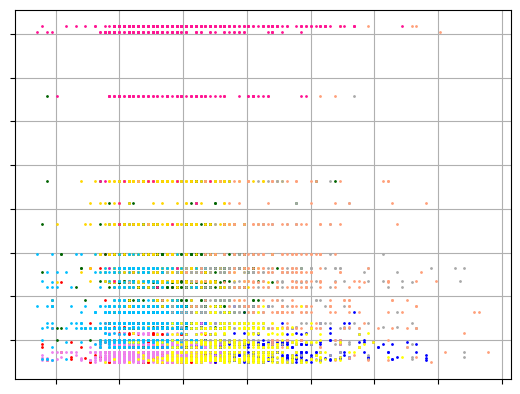

Numero totale di cluster: 10
Cluster 0: 906 elementi
Caratteristiche del cluster:
                                date    latitude   longitude  \
count                            906  906.000000  906.000000   
mean   2016-01-31 07:10:43.708609024   30.742882  -97.385734   
min              2014-01-01 00:00:00   25.892800 -106.502000   
25%              2015-01-18 06:00:00   29.503900  -98.369600   
50%              2016-02-29 12:00:00   30.036650  -97.275500   
75%              2017-02-06 12:00:00   32.707825  -96.651800   
max              2018-03-31 00:00:00   35.221000  -93.744600   
std                              NaN    1.780520    1.823774   

       congressional_district  avg_age_participants  n_participants_child  \
count              906.000000            906.000000            906.000000   
mean                26.572848             25.023179              0.038631   
min                  4.000000              2.000000              0.000000   
25%                 21.000000    

In [ ]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.mbsas import mbsas
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
import warnings
np.warnings = warnings

# Parametri per MBSAS
threshold = 0.6  # soglia di distanza
min_cluster_size = 5  # numero minimo di elementi in un cluster
sample_size = 10  # numero di campioni da utilizzare per la creazione di cluster iniziale

# Inizializza i cluster usando K-Means++
initial_centers = kmeans_plusplus_initializer(df_mississippi_scaled, sample_size).initialize()

# Crea un'istanza di MBSAS
mbsas_instance = mbsas(df_mississippi_scaled, len(initial_centers), threshold, min_cluster_size)
mbsas_instance.process()

# Ottieni i risultati del clustering
clusters = mbsas_instance.get_clusters()

# Trova i punti di rumore (punti non assegnati a nessun cluster)
noise_indices = [point_index for cluster in clusters for point_index in cluster]
all_points = set(range(len(df_mississippi_scaled)))
noise_indices = list(all_points - set(noise_indices))


# Visualizza i cluster utilizzando PCA
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, df_mississippi_scaled[:, 0:2], markersize=2)
visualizer.append_cluster(noise_indices, df_mississippi_scaled[:, 0:2], marker='x', markersize=5)
visualizer.show()

# Stampa informazioni sui singoli cluster
print(f"Numero totale di cluster: {len(clusters)}")

for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: {len(cluster)} elementi")
    print(f"Caratteristiche del cluster:")
    print(df_mississippi.iloc[cluster].describe())
    print("\n")

# Stampa informazioni sul rumore
print(f"Cluster NOISE (outlier): {len(noise_indices)} elementi")

In [ ]:
df_merged_clusterB.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131618 entries, 0 to 134578
Data columns (total 29 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   date                               131618 non-null  datetime64[ns]
 1   state                              131618 non-null  object        
 2   city_or_county                     131618 non-null  object        
 3   latitude                           131618 non-null  float64       
 4   longitude                          131618 non-null  float64       
 5   congressional_district             131618 non-null  int64         
 6   participant_age_group1             131618 non-null  category      
 7   participant_gender1                131618 non-null  category      
 8   avg_age_participants               131618 non-null  int64         
 9   n_participants_child               131618 non-null  int64         
 10  n_participants_teen      

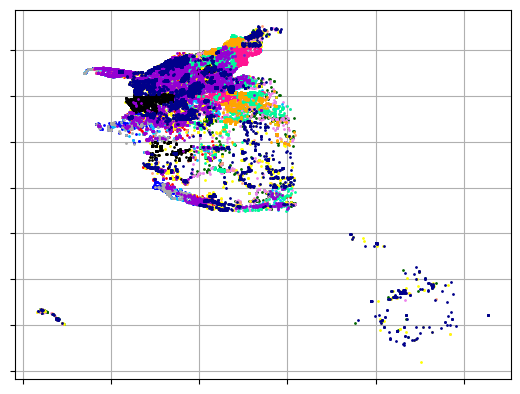

Numero totale di cluster: 15
Cluster 0: 14783 elementi
Caratteristiche del cluster:
       percentage_injured  avg_incident_density_per_district  \
count        14783.000000                       14783.000000   
mean            51.560260                        2285.576399   
std              6.123746                         872.380424   
min             34.816248                         407.972468   
25%             45.695364                        1684.466151   
50%             53.783342                        1966.426692   
75%             55.471192                        3220.168301   
max             70.237122                        6683.623326   

       congressional_district  unharmed_ratio  males_to_females_ratio  \
count            14783.000000    14783.000000            14783.000000   
mean                 8.063316        7.519930                0.906029   
std                  4.367246        2.779830                0.297180   
min                  1.000000        2.345189  

In [ ]:
from pyclustering.cluster import cluster_visualizer, mbsas
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from sklearn.preprocessing import StandardScaler
from pyclustering.cluster.mbsas import mbsas as MBSAS

# Seleziona colonne rilevanti
col_clustering_mbsas = ['percentage_injured', 'avg_incident_density_per_district', 'congressional_district', 'unharmed_ratio', 'males_to_females_ratio', 'povertyPercentage', 'avg_age_participants', 'latitude', 'longitude']

# Crea un DataFrame con le colonne selezionate
df_for_mbsas = df_merged_clusterB[col_clustering_mbsas]

# Standardizzazione dei dati
scaler = StandardScaler()
df_for_mbsas_scaled = scaler.fit_transform(df_for_mbsas)

# Parametri per MBSAS
threshold = 0.6  # soglia di distanza
min_cluster_size = 10  # numero minimo di elementi in un cluster
sample_size = 15 # numero di campioni da utilizzare per la creazione di cluster iniziale

# Inizializza i cluster usando K-Means++
initial_centers = kmeans_plusplus_initializer(df_for_mbsas_scaled[:, -2:], sample_size).initialize()  # Usiamo solo le colonne 'latitude' e 'longitude'

# Crea un'istanza di MBSAS
mbsas_instance = MBSAS(df_for_mbsas_scaled[:, :-2], len(initial_centers), threshold, min_cluster_size)  # Escludi le colonne 'latitude' e 'longitude'
mbsas_instance.process()

# Ottieni i risultati del clustering
clusters = mbsas_instance.get_clusters()

# Visualizza i cluster utilizzando PCA
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, df_for_mbsas_scaled[:, -2:], markersize=2)  # Usa solo le colonne 'latitude' e 'longitude' per la visualizzazione
visualizer.show()

# Stampa informazioni sui singoli cluster
print(f"Numero totale di cluster: {len(clusters)}")

for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: {len(cluster)} elementi")
    print(f"Caratteristiche del cluster:")
    print(df_for_mbsas.iloc[cluster].describe())
    print("\n")


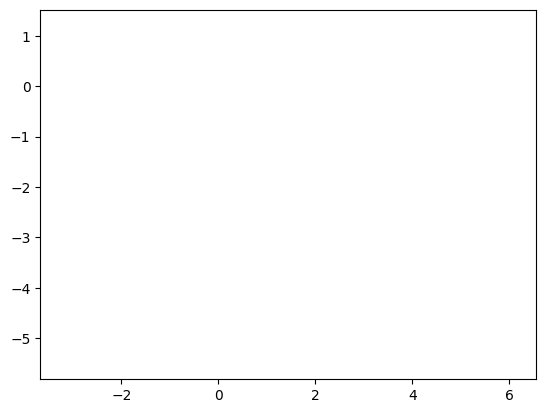

Numero totale di cluster: 10
Cluster 0: 16226 elementi
Caratteristiche del cluster:
       percentage_injured  avg_incident_density_per_district  \
count        16226.000000                       16226.000000   
mean            49.559815                        5995.040468   
std              6.771190                        1058.411546   
min             34.816248                        1684.466151   
25%             45.310907                        5324.818169   
50%             48.335855                        6575.057090   
75%             55.471192                        6683.623326   
max             65.822785                        6683.623326   

       congressional_district  unharmed_ratio  males_to_females_ratio  \
count            16226.000000    16226.000000            16226.000000   
mean                 2.642056        7.454421                1.407196   
std                  2.263301        2.754556                0.652697   
min                  1.000000        2.345189  

In [ ]:
from pyclustering.cluster import cluster_visualizer, mbsas
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from sklearn.preprocessing import StandardScaler
from pyclustering.cluster.mbsas import mbsas as MBSAS
import numpy as np
import matplotlib.pyplot as plt

# Seleziona colonne rilevanti
col_clustering_mbsas = ['percentage_injured', 'avg_incident_density_per_district', 'congressional_district', 'unharmed_ratio', 'males_to_females_ratio', 'povertyPercentage', 'avg_age_participants', 'latitude', 'longitude']

# Crea un DataFrame con le colonne selezionate
df_for_mbsas = df_merged_clusterB[col_clustering_mbsas]

# Standardizzazione dei dati
scaler = StandardScaler()
df_for_mbsas_scaled = scaler.fit_transform(df_for_mbsas)

# Parametri per MBSAS
threshold = 0.6  # soglia di distanza
min_cluster_size = 5  # numero minimo di elementi in un cluster
sample_size = 10  # numero di campioni da utilizzare per la creazione di cluster iniziale

# Inizializza i cluster usando K-Means++
initial_centers = kmeans_plusplus_initializer(df_for_mbsas_scaled[:, -2:], sample_size).initialize()  # Usiamo solo le colonne 'latitude' e 'longitude'

# Crea un'istanza di MBSAS
mbsas_instance = MBSAS(df_for_mbsas_scaled[:, :-2], len(initial_centers), threshold, min_cluster_size)  # Escludi le colonne 'latitude' e 'longitude'
mbsas_instance.process()

# Ottieni i risultati del clustering
clusters = mbsas_instance.get_clusters()

# Visualizza i cluster utilizzando PCA
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, df_for_mbsas_scaled[:, -2:], markersize=2)  # Usa solo le colonne 'latitude' e 'longitude' per la visualizzazione

# Inverti gli assi utilizzando Matplotlib
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

# Specifica l'intervallo degli assi
plt.xlim(df_for_mbsas_scaled[:, -2].min(), df_for_mbsas_scaled[:, -2].max())
plt.ylim(df_for_mbsas_scaled[:, -1].min(), df_for_mbsas_scaled[:, -1].max())

plt.show()

# Stampa informazioni sui singoli cluster
print(f"Numero totale di cluster: {len(clusters)}")

for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: {len(cluster)} elementi")
    print(f"Caratteristiche del cluster:")
    print(df_for_mbsas.iloc[cluster].describe())
    print("\n")



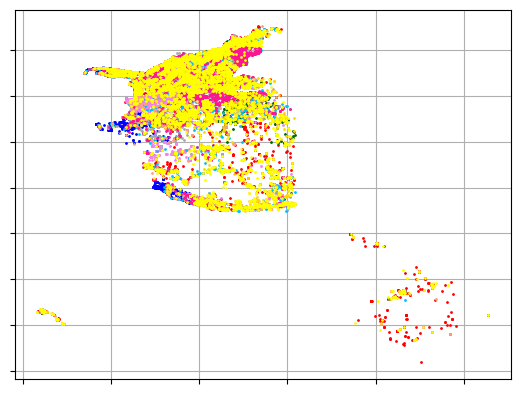

Numero totale di cluster: 10
Cluster 0: 16226 elementi
Caratteristiche del cluster:
       percentage_injured  avg_incident_density_per_district  \
count        16226.000000                       16226.000000   
mean            49.559815                        5995.040468   
std              6.771190                        1058.411546   
min             34.816248                        1684.466151   
25%             45.310907                        5324.818169   
50%             48.335855                        6575.057090   
75%             55.471192                        6683.623326   
max             65.822785                        6683.623326   

       congressional_district  unharmed_ratio  males_to_females_ratio  \
count            16226.000000    16226.000000            16226.000000   
mean                 2.642056        7.454421                1.407196   
std                  2.263301        2.754556                0.652697   
min                  1.000000        2.345189  

In [ ]:
from pyclustering.cluster import cluster_visualizer, mbsas
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from sklearn.preprocessing import StandardScaler
from pyclustering.cluster.mbsas import mbsas as MBSAS

# Seleziona colonne rilevanti
col_clustering_mbsas = ['percentage_injured', 'avg_incident_density_per_district', 'congressional_district', 'unharmed_ratio', 'males_to_females_ratio', 'povertyPercentage', 'avg_age_participants', 'latitude', 'longitude']

# Crea un DataFrame con le colonne selezionate
df_for_mbsas = df_merged_clusterB[col_clustering_mbsas]

# Standardizzazione dei dati
scaler = StandardScaler()
df_for_mbsas_scaled = scaler.fit_transform(df_for_mbsas)

# Parametri per MBSAS
threshold = 0.6  # soglia di distanza
min_cluster_size = 5  # numero minimo di elementi in un cluster
sample_size = 10  # numero di campioni da utilizzare per la creazione di cluster iniziale

# Inizializza i cluster usando K-Means++
initial_centers = kmeans_plusplus_initializer(df_for_mbsas_scaled[:, -2:], sample_size).initialize()  # Usiamo solo le colonne 'latitude' e 'longitude'

# Crea un'istanza di MBSAS
mbsas_instance = MBSAS(df_for_mbsas_scaled[:, :-2], len(initial_centers), threshold, min_cluster_size)  # Escludi le colonne 'latitude' e 'longitude'
mbsas_instance.process()

# Ottieni i risultati del clustering
clusters = mbsas_instance.get_clusters()

# Visualizza i cluster utilizzando PCA
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, df_for_mbsas_scaled[:, -2:], markersize=2)  # Usa solo le colonne 'latitude' e 'longitude' per la visualizzazione
visualizer.show()

# Stampa informazioni sui singoli cluster
print(f"Numero totale di cluster: {len(clusters)}")

for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: {len(cluster)} elementi")
    print(f"Caratteristiche del cluster:")
    print(df_for_mbsas.iloc[cluster].describe())
    print("\n")


using distance metric, work on numerical features we remove the categorical data

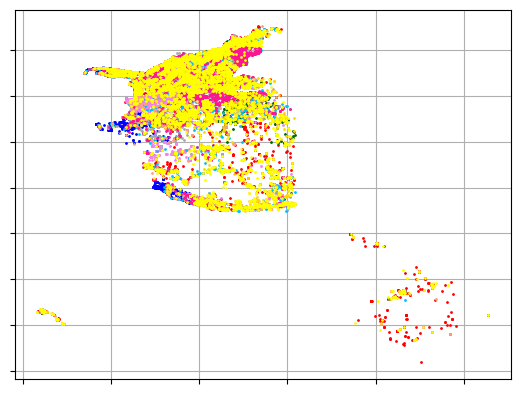

Numero totale di cluster: 10
Cluster 0: 16226 elementi
Caratteristiche del cluster:
       percentage_injured  avg_incident_density_per_district  \
count        16226.000000                       16226.000000   
mean            49.559815                        5995.040468   
std              6.771190                        1058.411546   
min             34.816248                        1684.466151   
25%             45.310907                        5324.818169   
50%             48.335855                        6575.057090   
75%             55.471192                        6683.623326   
max             65.822785                        6683.623326   

       congressional_district  unharmed_ratio  males_to_females_ratio  \
count            16226.000000    16226.000000            16226.000000   
mean                 2.642056        7.454421                1.407196   
std                  2.263301        2.754556                0.652697   
min                  1.000000        2.345189  

In [ ]:
from pyclustering.cluster import cluster_visualizer, mbsas
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from sklearn.preprocessing import StandardScaler
from pyclustering.cluster.mbsas import mbsas as MBSAS

# Seleziona colonne rilevanti
col_clustering_mbsas = ['percentage_injured', 'avg_incident_density_per_district', 'congressional_district', 'unharmed_ratio', 'males_to_females_ratio', 'povertyPercentage', 'avg_age_participants', 'latitude', 'longitude']

# Crea un DataFrame con le colonne selezionate
df_for_mbsas = df_merged_clusterB[col_clustering_mbsas]

# Standardizzazione dei dati
scaler = StandardScaler()
df_for_mbsas_scaled = scaler.fit_transform(df_for_mbsas)

# Parametri per MBSAS
threshold = 0.6  # soglia di distanza
min_cluster_size = 5  # numero minimo di elementi in un cluster
sample_size = 10  # numero di campioni da utilizzare per la creazione di cluster iniziale

# Inizializza i cluster usando K-Means++
initial_centers = kmeans_plusplus_initializer(df_for_mbsas_scaled[:, -2:], sample_size).initialize()  # Usiamo solo le colonne 'latitude' e 'longitude'

# Crea un'istanza di MBSAS
mbsas_instance = MBSAS(df_for_mbsas_scaled[:, :-2], len(initial_centers), threshold, min_cluster_size)  # Escludi le colonne 'latitude' e 'longitude'
mbsas_instance.process()

# Ottieni i risultati del clustering
clusters = mbsas_instance.get_clusters()

# Visualizza i cluster utilizzando PCA
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, df_for_mbsas_scaled[:, -2:], markersize=2)  # Usa solo le colonne 'latitude' e 'longitude' per la visualizzazione
visualizer.show()

# Stampa informazioni sui singoli cluster
print(f"Numero totale di cluster: {len(clusters)}")

for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: {len(cluster)} elementi")
    print(f"Caratteristiche del cluster:")
    print(df_for_mbsas.iloc[cluster].describe())
    print("\n")


In [ ]:
df_merged_clusterB.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131618 entries, 0 to 134578
Data columns (total 29 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   date                               131618 non-null  datetime64[ns]
 1   state                              131618 non-null  object        
 2   city_or_county                     131618 non-null  object        
 3   latitude                           131618 non-null  float64       
 4   longitude                          131618 non-null  float64       
 5   congressional_district             131618 non-null  int64         
 6   participant_age_group1             131618 non-null  category      
 7   participant_gender1                131618 non-null  category      
 8   avg_age_participants               131618 non-null  int64         
 9   n_participants_child               131618 non-null  int64         
 10  n_participants_teen      

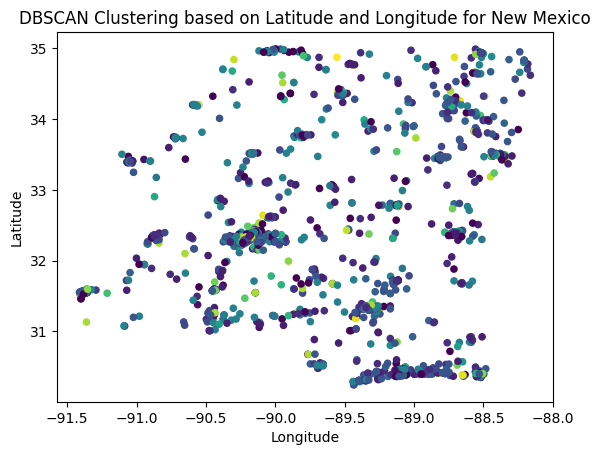

In [ ]:
df_newMexico = df_merged_clusterB[df_merged_clusterB['state'] == 'Mississippi']

# columns for clustering
selected_columns = ['n_killed', 'n_injured', 'males_to_females_ratio', 'n_participants_teen', 'avg_age_participants']
Y = df_newMexico[selected_columns]

# Standardizza i dati Z-score
scaler = StandardScaler()
Y_scaled = scaler.fit_transform(Y)

# Applica DBSCAN
dbscan = DBSCAN(eps=1, min_samples=10)
dbscan.fit(Y_scaled)

# Visualizza il risultato del clustering su latitudine e longitudine
plt.scatter(df_newMexico['longitude'], df_newMexico['latitude'], c=dbscan.labels_, cmap='viridis', s=20)
plt.title('DBSCAN Clustering based on Latitude and Longitude for New Mexico')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Avoid the bias given by the range of the different attribute by normalization.

In [ ]:
# considering new mexico because has the greatest poverty percentage
df_mississ = df_merged_clusterB[df_merged_clusterB['state'] == 'Mississippi']
# columns for clustering
#selected_columns = ['density_incident_state', 'males_to_females_ratio','percentage_injured','min_age_participants','max_age_participants','n_participants_child','n_participants_teen', 'n_females', 'n_killed','n_injured','n_arrested','n_unharmed','n_participants', 'unharmed_ratio']
selected_columns = ['n_killed','n_injured','males_to_females_ratio','n_participants_teen', 'percentage_injured','avg_incident_density_per_district']
Y = df_mississ[selected_columns]
# Standardizza i dati Z-score
scaler = StandardScaler()
scaler.fit(Y.values)

StandardScaler()

In [ ]:
Y.head()

,n_killed,n_injured,males_to_females_ratio,n_participants_teen,percentage_injured,avg_incident_density_per_district
16,1,0,1.0,1,49.906191,3220.168301
122,1,0,2.0,0,49.906191,3220.168301
139,1,0,2.0,0,49.906191,3220.168301
172,0,1,2.0,0,49.906191,6683.623326
184,0,0,3.0,0,49.906191,6683.623326


In [ ]:
scaler.transform(Y.head().values)

array([[ 9.08853512e-01, -7.18556377e-01, -7.42519574e-01,
         2.09696002e+00,  7.10542736e-15, -1.15314531e+00],
       [ 9.08853512e-01, -7.18556377e-01,  5.14744339e-01,
        -3.28568257e-01,  7.10542736e-15, -1.15314531e+00],
       [ 9.08853512e-01, -7.18556377e-01,  5.14744339e-01,
        -3.28568257e-01,  7.10542736e-15, -1.15314531e+00],
       [-8.32157013e-01,  9.45854822e-01,  5.14744339e-01,
        -3.28568257e-01,  7.10542736e-15,  1.60889255e+00],
       [-8.32157013e-01, -7.18556377e-01,  1.77200825e+00,
        -3.28568257e-01,  7.10542736e-15,  1.60889255e+00]])

In [ ]:
scaler.inverse_transform(scaler.transform(Y.head().values))

array([[1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        4.99061914e+01, 3.22016830e+03],
       [1.00000000e+00, 0.00000000e+00, 2.00000000e+00, 0.00000000e+00,
        4.99061914e+01, 3.22016830e+03],
       [1.00000000e+00, 0.00000000e+00, 2.00000000e+00, 0.00000000e+00,
        4.99061914e+01, 3.22016830e+03],
       [0.00000000e+00, 1.00000000e+00, 2.00000000e+00, 0.00000000e+00,
        4.99061914e+01, 6.68362333e+03],
       [0.00000000e+00, 0.00000000e+00, 3.00000000e+00, 0.00000000e+00,
        4.99061914e+01, 6.68362333e+03]])

In [ ]:
dbscan = DBSCAN(eps=0.9, min_samples=10)
dbscan.fit(Y)

DBSCAN(eps=0.9, min_samples=10)

Output:
* **labels_**: Cluster labels for each point in the dataset. Noisy samples are given the label -1.

In [ ]:
dbscan.labels_[:6]

array([ 0,  1,  1,  2, -1, -1])

size of each cluster

In [ ]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 array([443,  11,  51,  45,  42,  44,  38,  18,  95,  74,  49,  46,  15,
        131,  50,  12,  16,  94, 126,  61,  45,  20,  19,  62,  11,  12,
         53,  18,  52,  30,  13,  10,  10]))

Cluster visualization in 2 dim

In [ ]:
#plt.scatter(Y['min_age_participants'], Y['n_participants'], c=dbscan.labels_, s=20)
#plt.tick_params(axis='both', which='major', labelsize=22)
#plt.show()

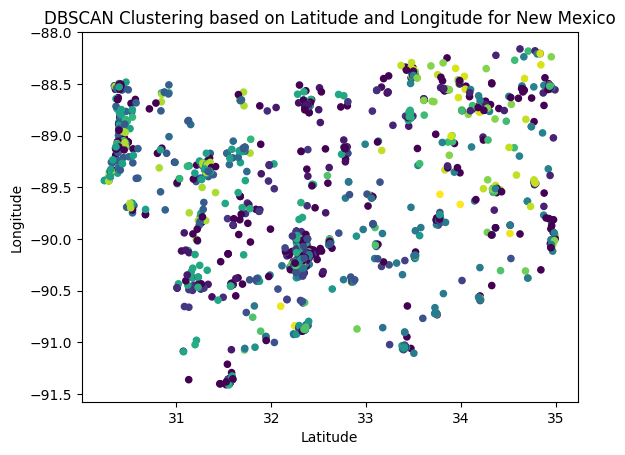

In [ ]:
# visualize the clusters according to latitude and longitude
plt.scatter(df_mississ['latitude'], df_mississ['longitude'], c=dbscan.labels_, cmap='viridis', s=20)
plt.title('DBSCAN Clustering based on Latitude and Longitude for New Mexico')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

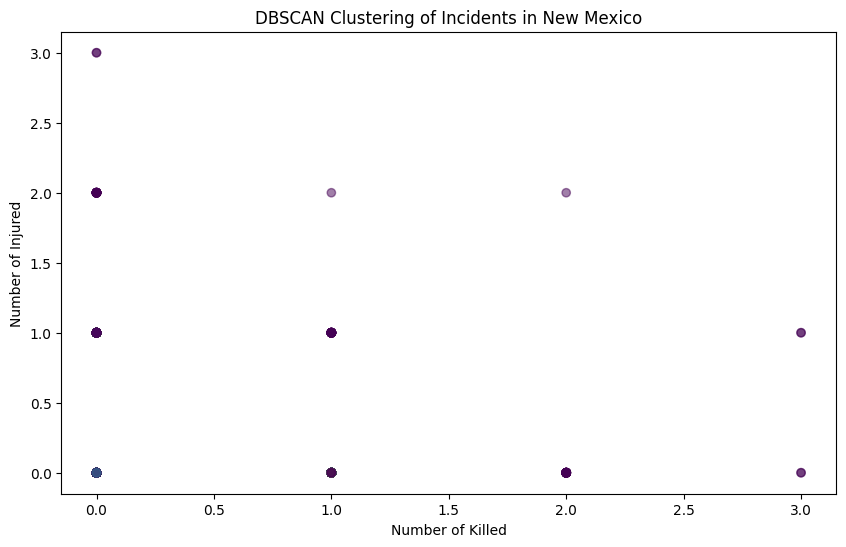

In [ ]:
col = ['n_killed', 'n_injured', 'n_participants', 'males_to_females_ratio', 'n_participants_teen','latitude','longitude']
df_state = df_merged_clusterB[df_merged_clusterB['state'] == 'New Mexico'][col]

# Standardizza i dati Z-score
scaler = StandardScaler()
state_df_scaled = scaler.fit_transform(df_state)

# Esegui DBSCAN
eps = 0.5  # Sostituisci con il valore appropriato
min_samples = 5  # Sostituisci con il valore appropriato
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
df_state['cluster'] = dbscan.fit_predict(state_df_scaled)

# Visualizza i risultati
plt.figure(figsize=(10, 6))
plt.scatter(df_state['n_killed'], df_state['n_injured'], c=df_state['cluster'], cmap='viridis', alpha=0.5)
plt.title('DBSCAN Clustering of Incidents in New Mexico')
plt.xlabel('Number of Killed')
plt.ylabel('Number of Injured')
plt.show()

In [ ]:
def run_dbscan_clustering(df, state, eps=0.2, min_samples=3):
    # Filtra il DataFrame per lo stato specificato
    state_df = df[df['state'] == state]

    # Seleziona le colonne rilevanti per il clustering
    #selected_columns = ['latitude', 'longitude','n_participants']
    selected_columns = ['n_participants', 'n_killed', 'n_injured']
    X = state_df[selected_columns]

    # Standardizza i dati Z-score
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Esegui DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    state_df['cluster'] = dbscan.fit_predict(X_scaled)

    # Analisi dei parametri di clustering
    n_clusters = len(set(state_df['cluster'])) - (1 if -1 in state_df['cluster'] else 0)
    print(f'Number of clusters: {n_clusters}')

    # Caratterizzazione e interpretazione dei cluster
    cluster_stats = state_df.groupby('cluster').agg({
        'latitude': 'mean',
        'longitude': 'mean',
        'n_killed': 'sum',
        'n_injured': 'sum',
        'n_participants': 'sum'
    })

    # Visualizzazione dei risultati
    for cluster_id, row in cluster_stats.iterrows():
        print(f'Cluster {cluster_id}:')
        print(f'  Centroid: ({row["n_killed"]}, {row["n_injured"]})')
        print(f'  Number of killed: {row["n_killed"]}')
        print(f'  Number of injured: {row["n_injured"]}')
        print(f'  Number of participants: {row["n_participants"]}')
        print('---')

    # Visualizzazione della distribuzione dei cluster sulla mappa (usa solo a scopo illustrativo)
    plt.scatter(state_df['latitude'], state_df['longitude'], c=state_df['cluster'], cmap='viridis')
    plt.title('DBSCAN Clustering')
    plt.xlabel('latitude')
    plt.ylabel('longitude')
    plt.show()

# Esempio di utilizzo
# run_dbscan_clustering(df_merged_clusterB, 'Illinois', eps=0.2, min_samples=5)

/tmp/ipykernel_84293/1926274680.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Number of clusters: 29
Cluster -1:
  Centroid: (35.0, 18.0)
  Number of killed: 35.0
  Number of injured: 18.0
  Number of participants: 60.0
---
Cluster 0:
  Centroid: (0.0, 0.0)
  Number of killed: 0.0
  Number of injured: 0.0
  Number of participants: 706.0
---
Cluster 1:
  Centroid: (0.0, 4718.0)
  Number of killed: 0.0
  Number of injured: 4718.0
  Number of participants: 4718.0
---
Cluster 2:
  Centroid: (1134.0, 0.0)
  Number of killed: 1134.0
  Number of injured: 0.0
  Number of participants: 1134.0
---
Cluster 3:
  Centroid: (0.0, 2370.0)
  Number of killed: 0.0
  Number of injured: 2370.0
  Number of participants: 4740.0
---
Cluster 4:
  Centroid: (0.0, 0.0)
  Number of killed: 0.0
  Number of injured: 0.0
  Number of participants: 1145.0
---
Cluster 5:
  Centroid: (715.0, 0.0)
  Number of killed: 715.0
  Number of injured: 0.0
  Number of participants: 1430.0
---
Cluster 6:
  Centroid: (0.0, 546.0)
  Number of killed: 0.0
  Number of injured: 546.0
  Number of participants: 

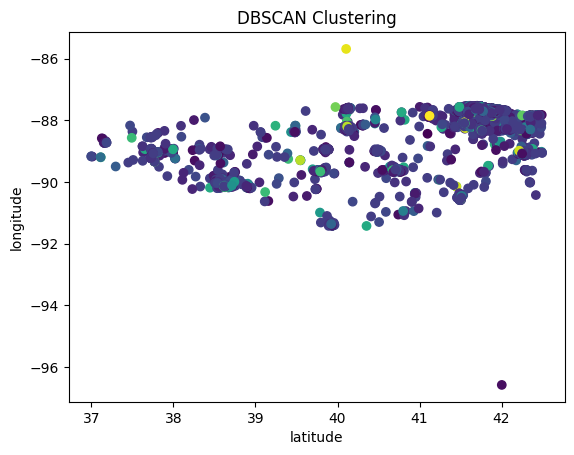

In [ ]:
run_dbscan_clustering(df_merged_clusterB, 'Illinois', eps=0.4, min_samples=7)